In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

case_pqtl_path = "/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_known_loci/known_pro_assoc/06.pqtl/CTEPH_pqtl_result.pkl"
control_pqtl_path = "/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_known_loci/known_pro_assoc/06.pqtl/NAGA_pqtl_result.pkl"

case_pqtl = pd.read_pickle(case_pqtl_path)
control_pqtl = pd.read_pickle(control_pqtl_path)

In [2]:
model = "additive"

In [3]:
from concurrent.futures import ThreadPoolExecutor

def process_key(key):
    case_ids = case_pqtl[key]['SeqId']
    control_ids = control_pqtl[key]['SeqId']
    unique_ids = case_ids[case_ids.isin(control_ids)].tolist()

    results = []
    for seq_id in unique_ids:
        if seq_id in case_pqtl[key]['SeqId'].values:
            case_row = case_pqtl[key][case_pqtl[key]['SeqId'] == seq_id]
            case_beta = case_row[f'{model}_beta'].iloc[0]
            case_pvalue = case_row[f'{model}_pvalue'].iloc[0]
            case_fdr = case_row[f'{model}_fdr'].iloc[0]
        else:
            case_beta = None
            case_pvalue = None
            case_fdr = None

        if seq_id in control_pqtl[key]['SeqId'].values:
            control_row = control_pqtl[key][control_pqtl[key]['SeqId'] == seq_id]
            control_beta = control_row[f'{model}_beta'].iloc[0]
            control_pvalue = control_row[f'{model}_pvalue'].iloc[0]
            control_fdr = control_row[f'{model}_fdr'].iloc[0]
        else:
            control_beta = None
            control_pvalue = None
            control_fdr = None

        results.append({
            'SeqId': seq_id,
            'case_beta': case_beta,
            'case_pvalue': case_pvalue,
            'case_fdr': case_fdr,
            'control_beta': control_beta,
            'control_pvalue': control_pvalue, 
            'control_fdr': control_fdr
        })

    return key, pd.DataFrame(results)

results_dict = {}

with ThreadPoolExecutor(max_workers=3) as executor:
    futures = {executor.submit(process_key, key): key for key in case_pqtl.keys()}
    for future in futures:
        key, result = future.result()
        results_dict[key] = result

In [4]:
plt.style.use('default')

In [5]:
key = 'chr1:169514323:T:C'

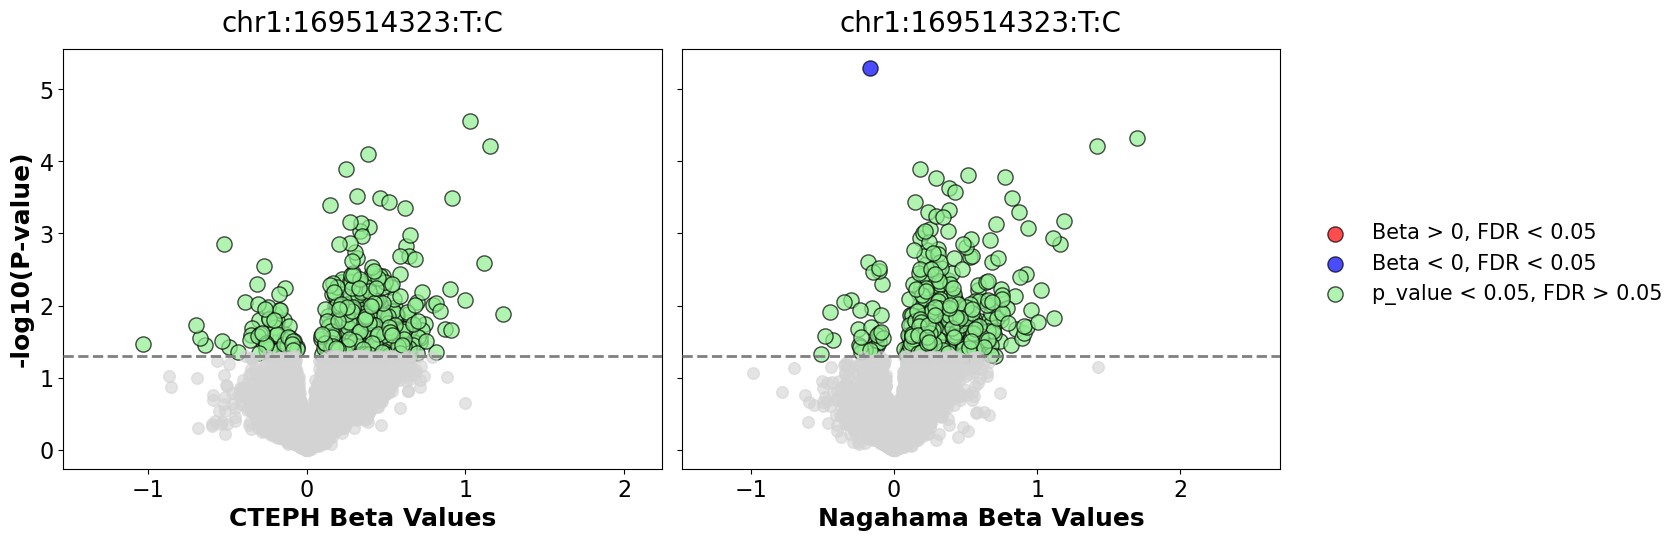

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

case_beta = results_dict[key]['case_beta']
case_pvalue = results_dict[key]['case_pvalue']
case_fdr = results_dict[key]['case_fdr']
control_beta = results_dict[key]['control_beta']
control_pvalue = results_dict[key]['control_pvalue']
control_fdr = results_dict[key]['control_fdr']

case_beta_series = pd.Series(case_beta)
case_pvalue_series = pd.Series(case_pvalue)
case_fdr_series = pd.Series(case_fdr)
control_beta_series = pd.Series(control_beta)
control_pvalue_series = pd.Series(control_pvalue)
control_fdr_series = pd.Series(control_fdr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6), sharey=True)

case_significant = case_fdr_series < 0.05
case_pvalue_significant = (case_pvalue_series < 0.05) & (case_fdr_series > 0.05)
ax1.scatter(case_beta_series[case_significant & (case_beta_series > 0)], -np.log10(case_pvalue_series[case_significant & (case_beta_series > 0)]),
            c='red', label='beta > 0', alpha=0.7, s=120, edgecolor='black')
ax1.scatter(case_beta_series[case_significant & (case_beta_series < 0)], -np.log10(case_pvalue_series[case_significant & (case_beta_series < 0)]),
            c='blue', label='beta < 0', alpha=0.7, s=120, edgecolor='black')
ax1.scatter(case_beta_series[case_pvalue_significant], -np.log10(case_pvalue_series[case_pvalue_significant]),
            c='lightgreen', label='p_value < 0.05, fdr > 0.05', alpha=0.7, s=120, edgecolor='black')
ax1.scatter(case_beta_series[~case_significant & ~case_pvalue_significant], -np.log10(case_pvalue_series[~case_significant & ~case_pvalue_significant]),
            c='lightgray', alpha=0.6, s=70, zorder=10)
ax1.axhline(y=-np.log10(0.05), color='gray', linestyle='--', linewidth=2, zorder=11)
ax1.set_xlabel('CTEPH Beta Values', fontsize=18, weight='bold')
ax1.set_ylabel('-log10(P-value)', fontsize=18, weight='bold')

control_significant = control_fdr_series < 0.05
control_pvalue_significant = (control_pvalue_series < 0.05) & (control_fdr_series > 0.05)
ax2.scatter(control_beta_series[control_significant & (control_beta_series > 0)], -np.log10(control_pvalue_series[control_significant & (control_beta_series > 0)]),
            c='red', label='beta > 0', alpha=0.7, s=120, edgecolor='black')
ax2.scatter(control_beta_series[control_significant & (control_beta_series < 0)], -np.log10(control_pvalue_series[control_significant & (control_beta_series < 0)]),
            c='blue', label='beta < 0', alpha=0.7, s=120, edgecolor='black')
ax2.scatter(control_beta_series[control_pvalue_significant], -np.log10(control_pvalue_series[control_pvalue_significant]),
            c='lightgreen', label='p_value < 0.05, fdr > 0.05', alpha=0.7, s=120, edgecolor='black')
ax2.scatter(control_beta_series[~control_significant & ~control_pvalue_significant], -np.log10(control_pvalue_series[~control_significant & ~control_pvalue_significant]),
            c='lightgray', alpha=0.6, s=70, zorder=10)
ax2.axhline(y=-np.log10(0.05), color='gray', linestyle='--', linewidth=2, zorder=11)
ax2.set_xlabel('Nagahama Beta Values', fontsize=18, weight='bold')

ax1.set_xlim([case_beta_series.min() - 0.5, case_beta_series.max() + 1])
ax2.set_xlim([control_beta_series.min() - 0.5, control_beta_series.max() + 1])

ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

ax1.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='both', labelsize=16)

fig.legend(labels=['Beta > 0, FDR < 0.05', 'Beta < 0, FDR < 0.05', 'p_value < 0.05, FDR > 0.05'], loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False, fontsize=15, markerscale=1)

ax1.set_title(f'{key}', fontsize=20, y=1.02)
ax2.set_title(f'{key}', fontsize=20, y=1.02)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [12]:
keys = ['chr1:169514323:T:C', 'chr9:133261703:A:G']

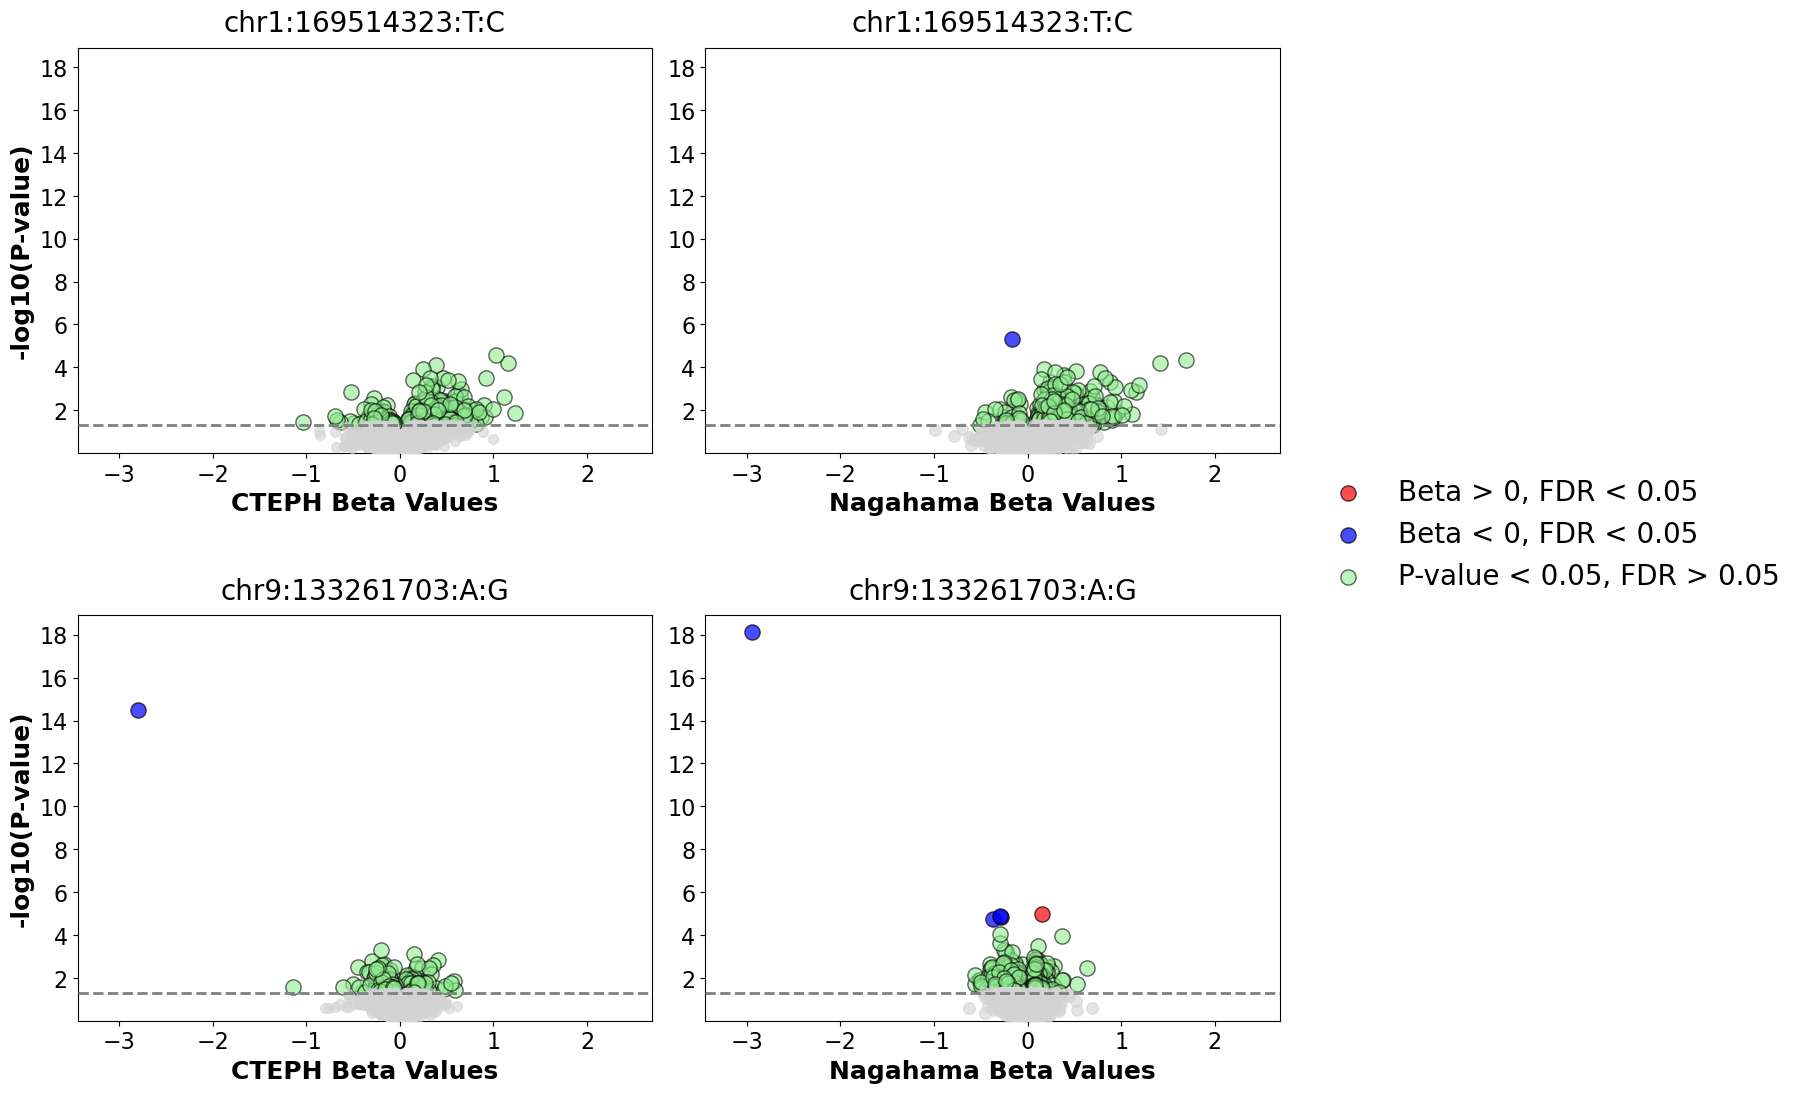

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

all_case_beta = []
all_control_beta = []
all_case_pvalue = []
all_control_pvalue = []

for key in keys:
    all_case_beta.extend(results_dict[key]['case_beta'])
    all_control_beta.extend(results_dict[key]['control_beta'])
    all_case_pvalue.extend(results_dict[key]['case_pvalue'])
    all_control_pvalue.extend(results_dict[key]['control_pvalue'])

min_beta = min(min(all_case_beta), min(all_control_beta)) - 0.5
max_beta = max(max(all_case_beta), max(all_control_beta)) + 1
min_pvalue = min(min(all_case_pvalue), min(all_control_pvalue))
max_pvalue = max(max(all_case_pvalue), max(all_control_pvalue))

fig, axes = plt.subplots(len(keys), 2, figsize=(13, 6 * len(keys)))

for i, key in enumerate(keys):

    case_beta = results_dict[key]['case_beta']
    case_pvalue = results_dict[key]['case_pvalue']
    case_fdr = results_dict[key]['case_fdr']
    control_beta = results_dict[key]['control_beta']
    control_pvalue = results_dict[key]['control_pvalue']
    control_fdr = results_dict[key]['control_fdr']

    case_beta_series = pd.Series(case_beta)
    case_pvalue_series = pd.Series(case_pvalue)
    case_fdr_series = pd.Series(case_fdr)
    control_beta_series = pd.Series(control_beta)
    control_pvalue_series = pd.Series(control_pvalue)
    control_fdr_series = pd.Series(control_fdr)

    ax1 = axes[i, 0]
    case_significant = case_fdr_series < 0.05
    case_pvalue_significant = (case_pvalue_series < 0.05) & (case_fdr_series > 0.05)
    ax1.scatter(case_beta_series[case_significant & (case_beta_series > 0)], -np.log10(case_pvalue_series[case_significant & (case_beta_series > 0)]),
                c='red', label='beta > 0', alpha=0.7, s=120, edgecolor='black')
    ax1.scatter(case_beta_series[case_significant & (case_beta_series < 0)], -np.log10(case_pvalue_series[case_significant & (case_beta_series < 0)]),
                c='blue', label='beta < 0', alpha=0.7, s=120, edgecolor='black')
    ax1.scatter(case_beta_series[case_pvalue_significant], -np.log10(case_pvalue_series[case_pvalue_significant]),
                c='lightgreen', alpha=0.6, s=120, zorder=10, edgecolor='black')
    ax1.scatter(case_beta_series[~case_significant & ~case_pvalue_significant], -np.log10(case_pvalue_series[~case_significant & ~case_pvalue_significant]),
                c='lightgray', alpha=0.6, s=50, zorder=10)
    ax1.axhline(y=-np.log10(0.05), color='gray', linestyle='--', linewidth=2, zorder=11)
    ax1.set_xlabel('CTEPH Beta Values', fontsize=18, weight='bold')
    ax1.set_ylabel('-log10(P-value)', fontsize=18, weight='bold')

    ax2 = axes[i, 1]
    control_significant = control_fdr_series < 0.05
    control_pvalue_significant = (control_pvalue_series < 0.05) & (control_fdr_series > 0.05)
    ax2.scatter(control_beta_series[control_significant & (control_beta_series > 0)], -np.log10(control_pvalue_series[control_significant & (control_beta_series > 0)]),
                c='red', label='beta > 0', alpha=0.7, s=120, edgecolor='black')
    ax2.scatter(control_beta_series[control_significant & (control_beta_series < 0)], -np.log10(control_pvalue_series[control_significant & (control_beta_series < 0)]),
                c='blue', label='beta < 0', alpha=0.7, s=120, edgecolor='black')
    ax2.scatter(control_beta_series[control_pvalue_significant], -np.log10(control_pvalue_series[control_pvalue_significant]),
                c='lightgreen', alpha=0.6, s=120, zorder=10, edgecolor='black')
    ax2.scatter(control_beta_series[~control_significant & ~control_pvalue_significant], -np.log10(control_pvalue_series[~control_significant & ~control_pvalue_significant]),
                c='lightgray', alpha=0.6, s=70, zorder=10)
    ax2.axhline(y=-np.log10(0.05), color='gray', linestyle='--', linewidth=2, zorder=11)
    ax2.set_xlabel('Nagahama Beta Values', fontsize=18, weight='bold')

    ax1.set_xlim([min_beta, max_beta])
    ax2.set_xlim([min_beta, max_beta])
    ax1.set_ylim([-np.log10(max_pvalue), -np.log10(min_pvalue) + 0.8])
    ax2.set_ylim([-np.log10(max_pvalue), -np.log10(min_pvalue) + 0.8])

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

    ax1.tick_params(axis='both', labelsize=16)
    ax2.tick_params(axis='both', labelsize=16)

    ax1.set_title(f'{key}', fontsize=20, y=1.02)
    ax2.set_title(f'{key}', fontsize=20, y=1.02)

fig.legend(labels=['Beta > 0, FDR < 0.05', 'Beta < 0, FDR < 0.05', 'P-value < 0.05, FDR > 0.05'], loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False, fontsize=20, markerscale=1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.subplots_adjust(hspace=0.4)  
plt.show()

In [18]:
keys = list(results_dict.keys())

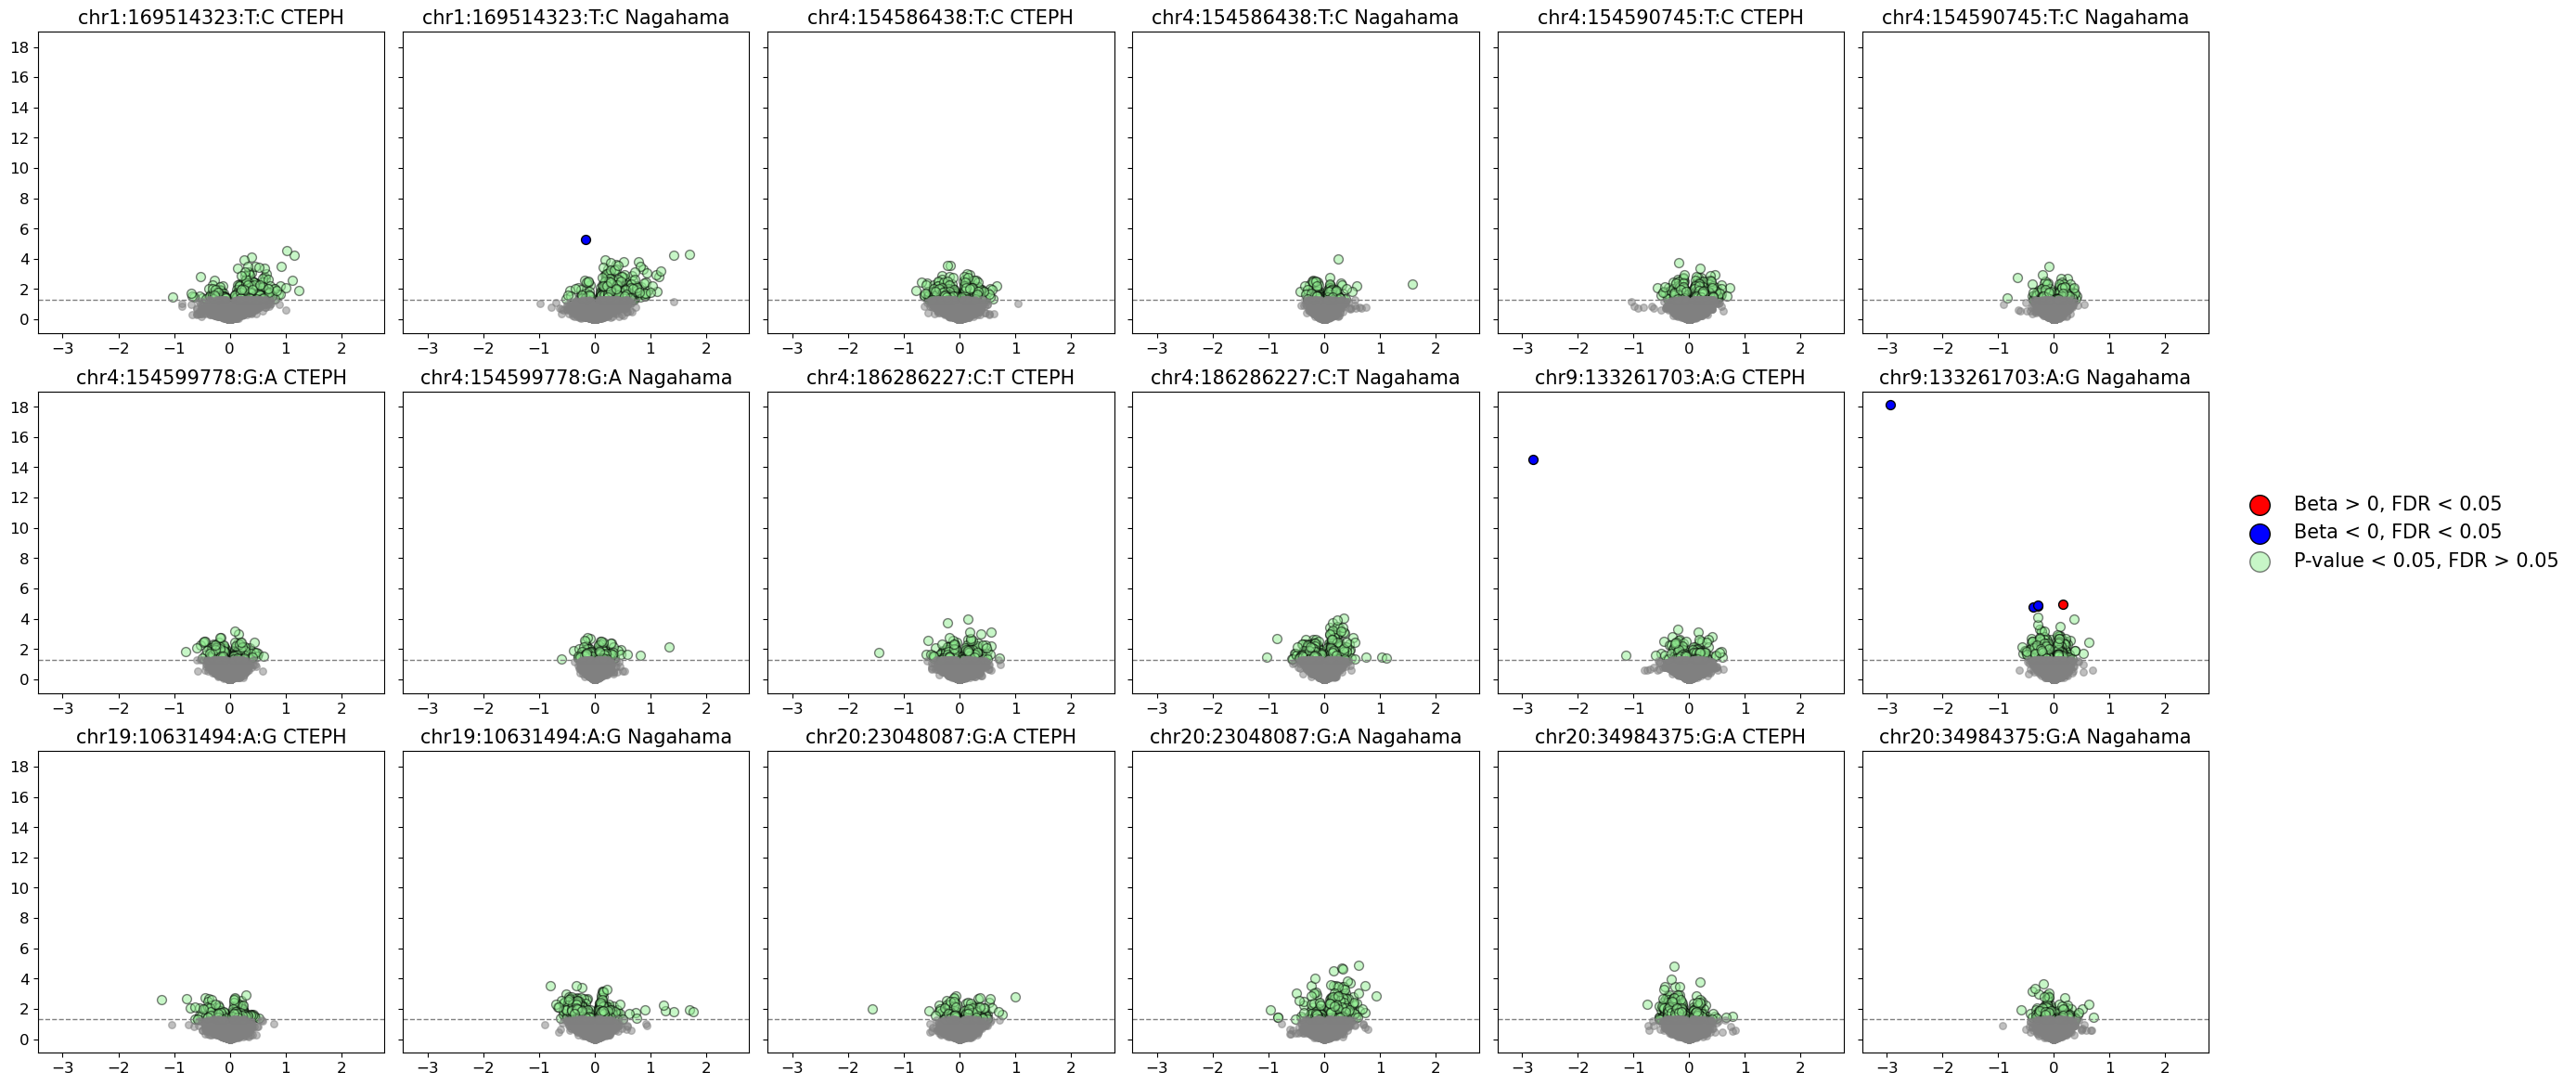

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

min_beta = min(min(beta for result in results_dict.values() for beta in result['case_beta']),
               min(beta for result in results_dict.values() for beta in result['control_beta'])) - 0.5
max_beta = max(max(beta for result in results_dict.values() for beta in result['case_beta']),
               max(beta for result in results_dict.values() for beta in result['control_beta'])) + 1


fig, axes = plt.subplots(3, 6, figsize=(24, 4 * 3), sharey=True)
axes = axes.flatten()  

for i, key in enumerate(keys):
    case_beta = results_dict[key]['case_beta']
    case_pvalue = results_dict[key]['case_pvalue']
    case_fdr = results_dict[key]['case_fdr']
    control_beta = results_dict[key]['control_beta']
    control_pvalue = results_dict[key]['control_pvalue']
    control_fdr = results_dict[key]['control_fdr']

    ax1 = axes[2 * i]  
    significant_case = np.array(case_fdr) < 0.05
    pvalue_significant_case = np.array(case_pvalue) < 0.05
    ax1.scatter(np.array(case_beta)[significant_case & (np.array(case_beta) > 0)],
                -np.log10(np.array(case_pvalue)[significant_case & (np.array(case_beta) > 0)]),
                c='red', label='Beta > 0, FDR < 0.05', s=50, edgecolor='black')
    ax1.scatter(np.array(case_beta)[significant_case & (np.array(case_beta) < 0)],
                -np.log10(np.array(case_pvalue)[significant_case & (np.array(case_beta) < 0)]),
                c='blue', label='Beta < 0, FDR < 0.05', s=50, edgecolor='black')
    ax1.scatter(np.array(case_beta)[pvalue_significant_case & ~significant_case],
                -np.log10(np.array(case_pvalue)[pvalue_significant_case & ~significant_case]),
                c='lightgreen', alpha=0.5, s=50, label='P-value < 0.05, FDR > 0.05', edgecolor='black')
    ax1.scatter(np.array(case_beta)[~pvalue_significant_case],
                -np.log10(np.array(case_pvalue)[~pvalue_significant_case]),
                c='gray', alpha=0.5, s=30)
    ax1.axhline(y=-np.log10(0.05), color='gray', linestyle='--', linewidth=1)

    ax2 = axes[2 * i + 1] 
    significant_control = np.array(control_fdr) < 0.05
    pvalue_significant_control = np.array(control_pvalue) < 0.05
    ax2.scatter(np.array(control_beta)[significant_control & (np.array(control_beta) > 0)],
                -np.log10(np.array(control_pvalue)[significant_control & (np.array(control_beta) > 0)]),
                c='red', s=50, edgecolor='black')
    ax2.scatter(np.array(control_beta)[significant_control & (np.array(control_beta) < 0)],
                -np.log10(np.array(control_pvalue)[significant_control & (np.array(control_beta) < 0)]),
                c='blue', s=50, edgecolor='black')
    ax2.scatter(np.array(control_beta)[pvalue_significant_control & ~significant_control],
                -np.log10(np.array(control_pvalue)[pvalue_significant_control & ~significant_control]),
                c='lightgreen', alpha=0.5, s=50, edgecolor='black')
    ax2.scatter(np.array(control_beta)[~pvalue_significant_control],
                -np.log10(np.array(control_pvalue)[~pvalue_significant_control]),
                c='gray', alpha=0.5, s=30)
    ax2.axhline(y=-np.log10(0.05), color='gray', linestyle='--', linewidth=1)

    ax1.set_title(f'{key} CTEPH', fontsize=15)
    ax2.set_title(f'{key} Nagahama', fontsize=15)
    ax1.set_xlim([min_beta, max_beta])
    ax2.set_xlim([min_beta, max_beta])
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax1.tick_params(axis='both', labelsize=12)
    ax2.tick_params(axis='both', labelsize=12)
    
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

fig.tight_layout()
fig.legend(['Beta > 0, FDR < 0.05', 'Beta < 0, FDR < 0.05', 'P-value < 0.05, FDR > 0.05'], loc='center left', ncol=1, frameon=False, fontsize=15, markerscale=2.2, bbox_to_anchor=(1.0, 0.5))
plt.subplots_adjust(top=0.95)
plt.show()